# Final Project BDA
### Student: Giorgio Rossi
Analysis of the vaccine impact in Italy: Twitter vs government data

## Libraries

In [1]:
import pandas as pd
from pymongo import MongoClient
from collections import Counter
import numpy as np
import operator
from datetime import datetime


import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 25)

## MongoDB Database

In [2]:
# Establish connection with database
client = MongoClient('localhost', 27017, username='mongoadmin', password='pass1234')
db = client.test
col = db.tweets

print('Connected!')

Connected!


## Structure of a tweet
references:
- [Tweet object](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet)
- [User object](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user)

In [3]:
import pprint
simple_tweet = db.tweets.find_one({})
pprint.pprint(simple_tweet)

{'_id': ObjectId('5fe94f63a37b7cb9ef72c3f5'),
 'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Dec 28 03:22:06 +0000 2020',
 'display_text_range': [60, 140],
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [{'display_url': 'twitter.com/i/web/status/1…',
                        'expanded_url': 'https://twitter.com/i/web/status/1343396781472800768',
                        'indices': [117, 140],
                        'url': 'https://t.co/EnTMfzQxYo'}],
              'user_mentions': [{'id': 1213772223825108993,
                                 'id_str': '1213772223825108993',
                                 'indices': [0, 15],
                                 'name': 'Enrico',
                                 'screen_name': 'Enrico55570937'},
                                {'id': 2382564510,
                                 'id_str': '2382564510',
                                 'indices': [16, 26],
                                 'n

In [4]:
my_tweets = db.tweets.find({},{'lang':1, '_id':0, 'text':1,
'entities.hashtags':1,'in_reply_to_status_id':1, 'is_quote_status':1,
'retweeted_status':1, 'user.screen_name':1, 'user.location':1})
numTweets = db.tweets.count()

print(f'The total number of tweets streamed is {numTweets}')

The total number of tweets streamed is 415432


## Languages

In [5]:
# Plot of Languages (autodetected by Twitter)
my_tweets.rewind() #Reset cursor
langsList = []
for t in my_tweets:
    langsList.append(t['lang'])
D = Counter(langsList)

Print(f'The only language available for the tweets is Italian')
D.most_common(5)

NameError: name 'Print' is not defined

## Most frequent hashtags

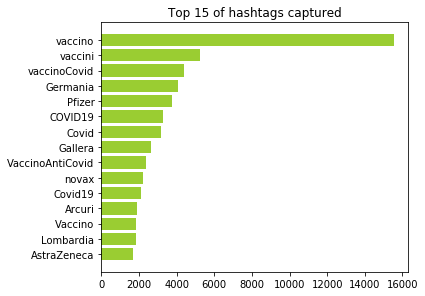

<Figure size 432x288 with 0 Axes>

In [6]:
# Plot hashtags
my_tweets.rewind()
hashList = []
for t in my_tweets:
    for e in t['entities']['hashtags']:
        h = e['text']
        hashList.append(h)
D = Counter(hashList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))


# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color =
'yellowgreen')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.tight_layout()
plt.title('Top 15 of hashtags captured')
plt.show()
plt.savefig('images/top_hashtag.png')

## Percentage of retweets, replies, quotations or original tweets

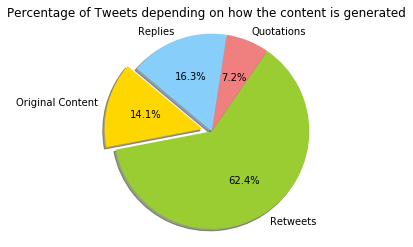

<Figure size 432x288 with 0 Axes>

In [7]:
# Plot how many of them are retweets, replies, quotations or original tweets
my_tweets.rewind() #Reset cursor
retweets = replies = quotations = originals = 0
for t in my_tweets:
    if t.get('retweeted_status') is not None:
        retweets=retweets+1
    elif t['is_quote_status'] is not False:
        quotations = quotations+1
    elif t.get('in_reply_to_status_id') is not None:
        replies = replies+1
    else:
        originals = originals+1


# ----------- Pie Chart ------------------------
labels = 'Original Content', 'Retweets', 'Quotations', 'Replies'
sizes = [originals, retweets, quotations, replies]
frequencies = [x/numTweets for x in sizes]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0) # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Tweets depending on how the content is generated')
plt.show()
plt.savefig('images/tweets_pie.png')

## Locations

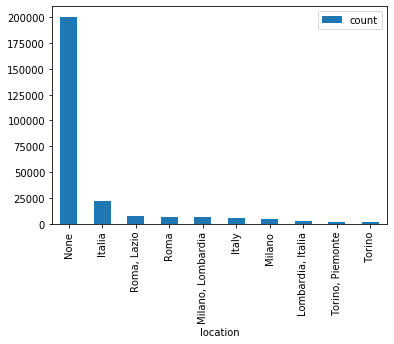

In [8]:
# locations
loc_list = []

for loc in col.find({}, {'user.location':1}):
    loc_list.append(loc['user']['location'])

loc_counter = Counter(loc_list)

locs = []
counts = []
for loc in loc_counter.most_common(10):
    locs.append(str(loc[0]))
    counts.append(loc[1])

# ----------- Vertical Bar Plot ------------------------
locations = pd.DataFrame({'location': locs, 'count': counts})
locations.plot.bar(x='location', y='count')
plt.savefig('images/locations_count.png')

I have to much missing value for the location attribute, so I have decided to discard this informations

## Analysis

In [9]:
# function for parsing the date of the tweet e retrieve the hour
def parse_datetime(tweet):
    dtime = tweet['created_at']
    new_datetime = datetime.strftime(datetime.strptime(dtime,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:00:00')
    return new_datetime


### All tweets

In [10]:
# all tweets
raw_tweets_all = db.tweets.find({}, {'created_at':1})
num_raw_tweet = raw_tweets_all.count()
num_raw_tweet


415432

### Influencers
Top 200 people with a lot of followers

In [11]:
# influencers
from bson.son import SON

pipeline = [
    {'$group': {'_id': '$user.screen_name', 'followers': {'$last':'$user.followers_count'}}},
    {"$sort": SON([("followers", -1)])},
    {'$limit': 200}
]
# ascending 1, descending -1

res = col.aggregate(pipeline)

influencers = []

print('First ten people (in IT) with a great amount of followers, tweeting on vaccine:')
index = 0
for sample in res:
    influencers.append(sample['_id'])
    if(index < 10):
        print(sample)
    index +=1

First ten people (in IT) with a great amount of followers, tweeting on vaccine:
{'_id': 'matteorenzi', 'followers': 3393684}
{'_id': 'SkyTG24', 'followers': 3185563}
{'_id': 'repubblica', 'followers': 3084405}
{'_id': 'SkySport', 'followers': 2534859}
{'_id': 'Corriere', 'followers': 2324015}
{'_id': 'redazioneiene', 'followers': 2308240}
{'_id': 'fattoquotidiano', 'followers': 2040869}
{'_id': 'Gazzetta_it', 'followers': 1763417}
{'_id': 'spinozait', 'followers': 1753552}
{'_id': 'marcotravaglio', 'followers': 1603971}


In [12]:
raw_tweets_influencers = db.tweets.find({'user.screen_name': { '$in': influencers}}, {'created_at':1, 'user.screen_name':1})
#num_raw_tweet = db.tweets.count()
num_raw_tweet = raw_tweets_influencers.count()
num_raw_tweet

2473

### Verified
Users with the verified profile

In [13]:
raw_tweets_verified = db.tweets.find({'user.verified': True}, {'created_at':1})
num_raw_tweet = raw_tweets_verified.count()
num_raw_tweet

4027

In [14]:
def parse_and_resample(raw_tweets):   
    # parse datetime
    tweets = []
    for tw in raw_tweets:
        tweets.append(parse_datetime(dict(tw)))

    # dataframe with all tweets
    index = pd.to_datetime(tweets)
    tweets_num = [1 for x in tweets]
    tweetframe = pd.DataFrame(tweets_num, columns=['tweets'], index = index)

    # resample
    new_df = pd.DataFrame()
    new_df['count'] = tweetframe.tweets.resample('H').sum()
    new_df['day'] = new_df.index.to_pydatetime()
    new_df['day'] = new_df['day'].apply(lambda date: datetime.strptime(str(date)[0:-9], '%Y-%m-%d'))

    return new_df

def plot_count(df):
    # ----------- Line Plot ------------------------
    df.ix[:,['count']].plot()
    plt.savefig('images/week_all_data.png')

In [15]:
tweets_verified = parse_and_resample(raw_tweets_verified)
tweets_influencers = parse_and_resample(raw_tweets_influencers)
new_df = parse_and_resample(raw_tweets_all)

In [16]:
compare_df = pd.DataFrame()

compare_df['verified'] = tweets_verified['count']#.reset_index(drop=True)
compare_df['influencers'] = tweets_influencers['count']#.reset_index(drop=True)
compare_df.head(10)

,verified,influencers
2020-12-28 04:00:00,3,2
2020-12-28 05:00:00,10,9
2020-12-28 06:00:00,42,34
2020-12-28 07:00:00,63,47
2020-12-28 08:00:00,44,27
2020-12-28 09:00:00,49,32
2020-12-28 10:00:00,61,38
2020-12-28 11:00:00,84,53
2020-12-28 12:00:00,41,25
2020-12-28 13:00:00,49,43


### "Verified" and "Influencer" user tweets and All tweets
Comparison between this two category about the pubblication of tweets in the week Dec 28th 2020 - Jan 3rd 2021, furthermore plot of the general pattern of the tweets published in the same week.


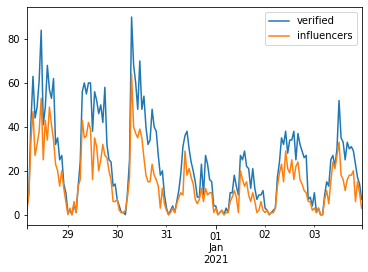

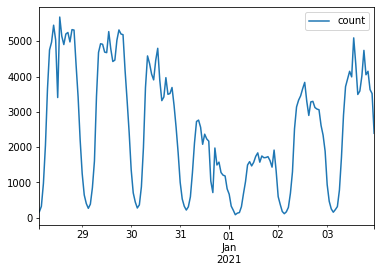

In [17]:
compare_df.plot()
plt.savefig('images/week_infl_ver.png')

plot_count(new_df)

### Hourly analysis of all tweets

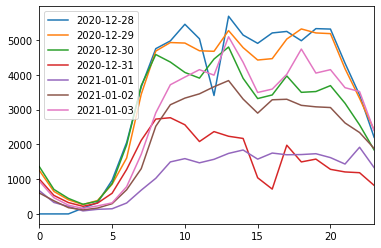

In [18]:
hours = new_df.groupby('day')

day_view = pd.DataFrame(index=range(24))

for day in hours.groups.keys():
    day_name = str(day)[0:-9]

    # first day
    if(day_name == '2020-12-28'):
        first_day_03_23 = pd.DataFrame(hours.get_group('2020-12-28')['count'].reset_index(drop=True))
        first_day_00_02 = pd.DataFrame({'count': [0, 0, 0]})
        first_day = pd.concat([first_day_00_02, first_day_03_23], ignore_index=True) 
        day_view['2020-12-28'] = first_day

    else:      
        day_view[day_name] = hours.get_group(day_name)['count'].reset_index(drop=True)


# ----------- Multi-Line Plot ------------------------
day_view.plot()  
plt.savefig('images/hours_all_line.png')      


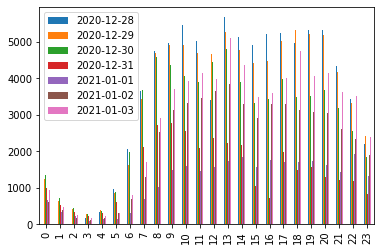

In [19]:
# ----------- Vertical Multi-Bar Plot ------------------------
day_view.plot.bar()
plt.savefig('images/hours_all_bar.png')

In [20]:
day_view.head(24)

,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03
0,0,1249,1359,1002,668,600,941
1,0,646,705,532,330,378,467
2,0,405,446,326,215,179,251
3,167,268,277,219,87,116,158
4,324,386,366,311,132,169,231
5,969,852,877,594,148,294,317
6,2055,1608,1987,1279,314,695,784
7,3652,3439,3689,2115,683,1300,1713
8,4752,4682,4583,2727,1024,2520,2906
9,4974,4928,4367,2766,1495,3139,3714


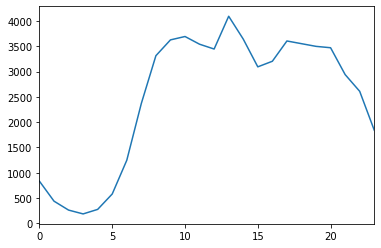

In [21]:
# weekly mean
day_view.mean(axis = 1).plot()
plt.savefig('images/day_all_line_avg.png')

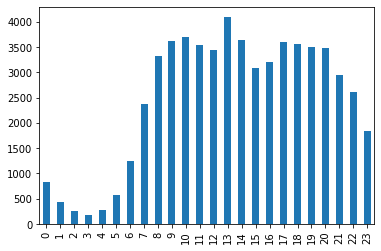

In [22]:
# weekly mean
day_view.mean(axis = 1).plot.bar()
plt.savefig('images/day_all_bar_avg.png')

## Vaccine Data
source: [Italian Government](https://app.powerbi.com/view?r=eyJrIjoiMzg4YmI5NDQtZDM5ZC00ZTIyLTgxN2MtOTBkMWM4MTUyYTg0IiwidCI6ImFmZDBhNzVjLTg2NzEtNGNjZS05MDYxLTJjYTBkOTJlNDIyZiIsImMiOjh9)

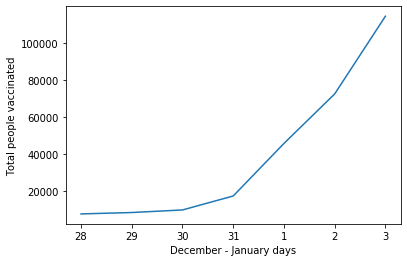

In [27]:
dates = pd.date_range(start="2020-12-28",end="2021-01-03").tolist()
x = [str(date.day) for date in dates]
y = [7609, 8361, 9750, 17291, 45667, 72397, 114349]

plt.plot(x, y)
plt.xlabel('December - January days')
plt.ylabel('Total people vaccinated')
plt.savefig('images/vaccine_total.png')

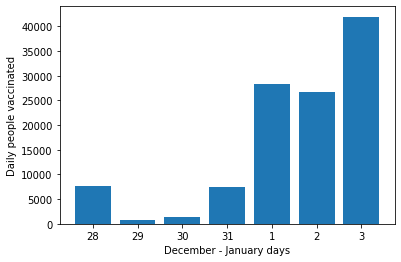

In [28]:
y_increment = []
last_value = 0
for index, value in enumerate(y):
    if(index == 0):
        y_increment.append(value)
    else:
        y_increment.append(value - last_value)
    last_value = value

plt.bar(x, y_increment)
plt.xlabel('December - January days')
plt.ylabel('Daily people vaccinated')
plt.savefig('images/vaccine_increment.png')